In [1]:
import sys
sys.path.append('../')

import tquant as tq

# from datetime import date, timedelta
# import tensorflow as tf
# import pandas as pd
from datastore import *


- togliere curve assignment --> ok
- nel pricer ois usare i forward della curva tasso --> ok
- aggiornare pricer depo
- aggiornare pricer ois
- far funzionare la curva con le sensy tf--> la curva fa rallentare tutto

In [2]:
def modifica_stringhe(lista_stringhe):
    # Lista per memorizzare le stringhe modificate
    stringhe_modificate = []
    
    # Rimozione del prefisso FRA
    prefisso = "FRA-"
    for stringa in lista_stringhe:
        if stringa.startswith(prefisso):
            stringa = stringa[len(prefisso):]
        stringhe_modificate.append(stringa)

    # Dizionario delle sostituzioni
    sostituzioni = {
        "1BD": "O/N",
        "2BD": "T/N",
        "3BD": "S/N",
        "CASH": "depo",
        "SWAP": "ois",
        "FRA": "fra",
    }

    # Lista temporanea per memorizzare le stringhe modificate ulteriormente
    stringhe_modificate_finali = []

    # Iterare su ciascuna stringa nella lista delle stringhe modificate
    for stringa in stringhe_modificate:
        for chiave, valore in sostituzioni.items():
            stringa = stringa.replace(chiave, valore)
        stringhe_modificate_finali.append(stringa)
    
    return stringhe_modificate_finali

In [3]:
tq.Settings.evaluation_date = date(2024, 4, 30)

#bootstrap della estr
generators = modifica_stringhe(ir_eur_curve_estr['type'])
maturities = list(modifica_stringhe(ir_eur_curve_estr['tenor']))
data = [["EUR", "DISCOUNT", "", "EUR:ESTR"]]
attributes = ["CCY", "USAGE"]
curve_assignment = tq.CurveAssignment(data, attributes)

depo_builder = tq.DepositBuilderAP("depo",
                                "USD",
                                2,
                                tq.BusinessDayConvention.ModifiedFollowing,
                                tq.DayCounterConvention.Actual360,
                                1.0)
ois_builder = tq.OisBuilderAP("ois",
                        "USD",
                        2,
                        2,
                        "1Y",
                        "1Y",
                        tq.BusinessDayConvention.ModifiedFollowing,
                        1.0,
                        tq.DayCounterConvention.Actual360,
                        tq.DayCounterConvention.Actual360)
generator_map = {"depo": depo_builder, "ois": ois_builder}

# PricerFactory

In [4]:
class PricerFactory:
    """ 
    passa il curve_name
    
    """
    @staticmethod
    def create(product: tq.Product, curve_name: str):
        if type(product) == tq.DepositAP:
            return tq.DepositPricerTest(curve_name)
        elif type(product) == tq.OisAP or type(product) == tq.OisTest:
            return tq.OisPricerTest(curve_name)
        else:
            raise TypeError(f"{product} is a wrong product type")

# Zero Curve Stripper

In [5]:
class ObjectiveFunction:
    def __init__(self,
                 trade_date: date,
                 rate_curve: tq.RateCurve,
                 products: list[tq.Product],
                 pricers: list[tq.AbstractPricerAP],
                 curves: dict[str, tq.RateCurve]):
        self.trade_date = trade_date
        self.rate_curve = rate_curve
        self.products = products
        self.pricers = pricers
        self.curves = curves

    def __call__(self, x):
        self.rate_curve.set_rates(x)
        res = np.zeros(len(self.pricers))
        for i, (pricer, product) in enumerate(zip(self.pricers, self.products)):
            res[i] = pricer.price(product, self.trade_date, self.curves)
        return res


In [6]:
bootstrapping_curve_name = "EUR:ESTR"
trade_date = tq.Settings.evaluation_date
# generators 
# maturities
quotes = ir_eur_curve_estr['quote'].values
# curve_assignment
# generator_map
market_data = {}
solver_type = "GLOBAL"
is_spread_curve = False

In [7]:
bootstrapping_curve_name

'EUR:ESTR'

In [8]:
print(bootstrapping_curve_name)
products = []
pricers = []
for i, generator in enumerate(generators):
    builder = generator_map[generator]
    product = builder.build(trade_date, quotes[i], maturities[i])
    products.append(product)
    #print(maturities[i])
    #print(product)
    # pricer = PricerFactory.create(product, curve_assignment)
    pricer = PricerFactory.create(product, bootstrapping_curve_name)
    pricers.append(pricer)
pillars = []
zero_rates = []
act365 = tq.DayCounterConvention.Actual365
day_counter = tq.DayCounter(act365)
for i in range(len(maturities)):
    pillars.append(day_counter.year_fraction(trade_date, products[i].maturity))
    zero_rates.append(0.01)
if is_spread_curve:
    # base_curve = market_data[base_curve_name]
    # bootstrapping_curve = SpreadCurve(pillars, zero_rates, base_curve)
    pass
else:
    bootstrapping_curve = tq.RateCurveAP(pillars, zero_rates, 'LINEAR')
market_data[bootstrapping_curve_name] = bootstrapping_curve

# bootstrapping
func = ObjectiveFunction(trade_date,
                        bootstrapping_curve,
                        products,
                        pricers,
                        market_data)
x = np.array(zero_rates).astype(np.float64) # initial guess
bootstrapped_rates, rates_jac = tq.newton_multidimensional(func, x)
bootstrapping_curve.set_rates(bootstrapped_rates)


EUR:ESTR


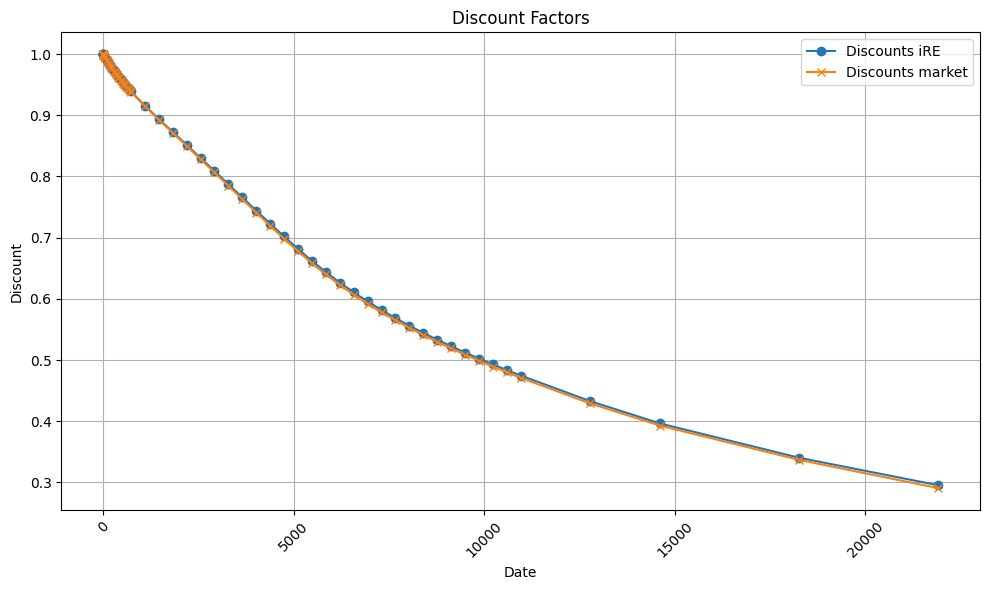

In [11]:
import matplotlib.pyplot as plt
estr_ire = bootstrapping_curve
discount_estr_ire = []
fwd_estr_ire = []
discounts_estr_mkt = ir_eur_disc_estr
for maturity in discounts_estr_mkt['daycount'].values/365:
    discount_estr_ire.append(estr_ire.discount(maturity))
    fwd_estr_ire.append(estr_ire.inst_fwd(maturity))
    
# Plot discount factors nostri vs market
plt.figure(figsize=(10, 6))
plt.plot(discounts_estr_mkt['daycount'].values, discount_estr_ire, label= 'Discounts iRE', marker='o', linestyle='-')
plt.plot(discounts_estr_mkt['daycount'].values, discounts_estr_mkt['market_quote'].values, label= 'Discounts market', marker='x', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Discount')
plt.title('Discount Factors')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()

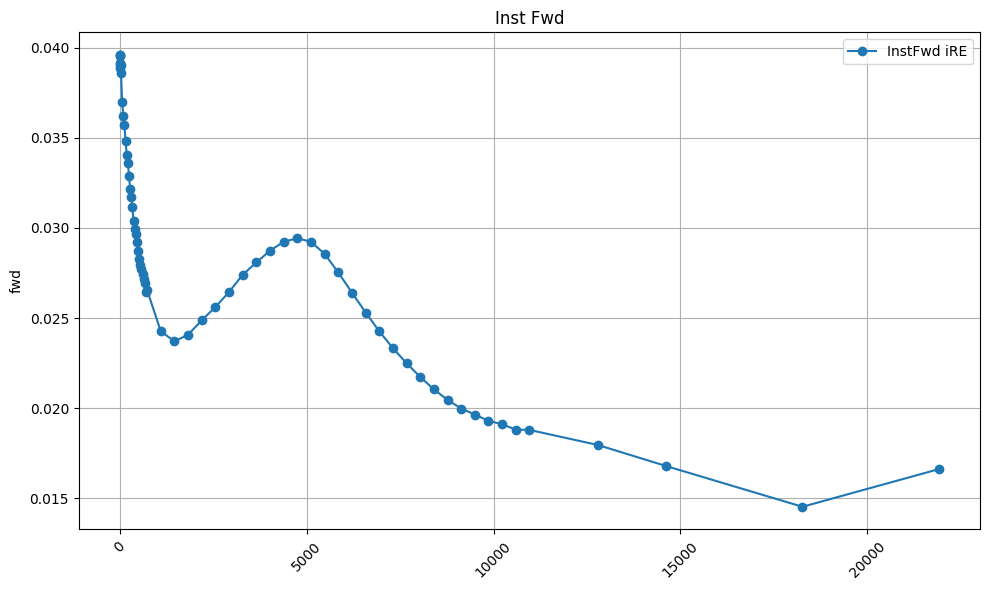

In [12]:
plt.figure(figsize=(10, 6))
plt.title('Inst Fwd')
plt.plot(discounts_estr_mkt['daycount'].values, fwd_estr_ire, label= 'InstFwd iRE', marker='o', linestyle='-')
plt.ylabel('fwd')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Mostrare il grafico
plt.show()